## YoloV1 아키텍쳐구현

In [62]:
import torchvision.models as models
import torchvision
import torch.nn as nn
import numpy as np
import torch
import os
import pandas as pd
import cv2
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from ipywidgets import interact
from collections import defaultdict

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Feb  5 04:28:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Yolov1 모델링

In [4]:
class YOLOv1_RESNET(nn.Module):
  def __init__(self, numClasses):
    super().__init__()
    self.numBBoxes = 2
    self.numClasses = numClasses
    self.gridSize = 7
    resnet18 = models.resnet18()
    layers = [m for m in resnet18.children()]
    self.backbone = nn.Sequential(*layers[:-2])

    self.head = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, padding=0, bias=False ),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False ),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False ),
        nn.BatchNorm2d(1024),
        nn.ReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1, bias=False ),
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.Conv2d(in_channels=1024, out_channels=(4+1)*self.numBBoxes+self.numClasses, kernel_size=1, padding=0, bias=False),
        nn.AdaptiveAvgPool2d(output_size = (self.gridSize, self.gridSize))
    )

  def forward(self, x):
    x = self.backbone(x)
    y = self.head(x) # input (batch, 3, 448, 448) -> output feature (batch, 12, 7, 7)
    return y

In [5]:
NUM_CLASSES = 2
model = YOLOv1_RESNET(numClasses=NUM_CLASSES)

In [6]:
x = torch.rand((1, 3, 448, 448))
y = model(x)
y.shape

torch.Size([1, 12, 7, 7])

### 이미지위에 bounding box 띄워보기 & 데이터셋 구축(dataset, dataloader, transformer) 

#### 이미지위에 bounding box 띄워보기

In [7]:
data_dir ="/content/drive/MyDrive/fastCamMedicalProj/DATASET/DATASET/Detection"
phase = 'train'
image_files = [fn for fn in os.listdir(os.path.join(data_dir, phase)) if fn.endswith("jpg")]
image_files[0]

'd18b6e7c07fe206b.jpg'

In [8]:
INDEX=0

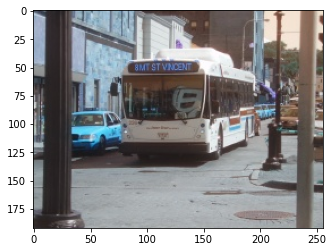

In [9]:
image_pth = "/content/drive/MyDrive/fastCamMedicalProj/DATASET/DATASET/Detection/train/"+image_files[INDEX]
img = cv2.imread(image_pth,cv2.IMREAD_COLOR)
plt.imshow(img)

In [10]:
image_id = image_files[INDEX].split(".")[0]
image_id

'd18b6e7c07fe206b'

In [11]:
data_df = pd.read_csv(os.path.join(data_dir,'df.csv'))
label_metadata = data_df.loc[data_df['ImageID']==image_id]

bboxes = label_metadata[["XMin", "XMax","YMin","YMax"]].values
# ["XMin", "XMax","YMin","YMax"] -> ['x_cen','y_cen','width','height']
bboxes[:, [1,2]] = bboxes[:, [2,1]]
bboxes[:, 2:4] -= bboxes[:, 0:2]
bboxes[:, 0:2] += (bboxes[:, 2:4] / 2)

In [12]:
bboxes[0]

array([0.513281 , 0.4354165, 0.498438 , 0.516667 ])

In [13]:
def myFig(img, label):
  fig, ax = plt.subplots()

  ax.imshow(img)

  if len(label)>0:
    dw = img.shape[1]
    dh = img.shape[0]

    x1 = (label[0][0] - label[0][2] / 2) * dw
    y1 = (label[0][1] - label[0][3] / 2) * dh
    w = label[0][2]* dw
    h = label[0][3]* dh

    rect = patches.Rectangle((x1, y1) , w, h, linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
  
  plt.show()

In [14]:
img.shape

(192, 256, 3)

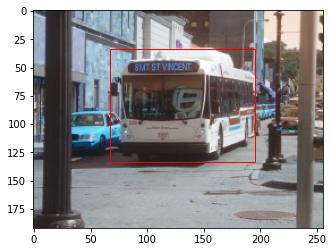

In [15]:
myFig(img, bboxes)

In [16]:
print(img.shape)
print(bboxes)

(192, 256, 3)
[[0.513281  0.4354165 0.498438  0.516667 ]]


In [17]:
SIZE = 100
test_transform = A.Compose(
    [
        A.LongestMaxSize(max_size=SIZE)
    ],
    bbox_params = A.BboxParams(format='yolo',min_visibility=0.4, label_fields=[],),
)
transformed = test_transform(image=img, bboxes=bboxes)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']

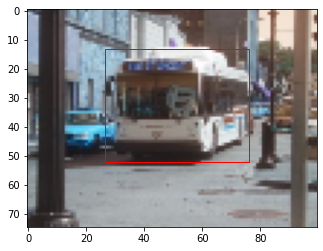

In [18]:
myFig(transformed_image, transformed_bboxes)

In [19]:
print(transformed_image.shape)
print(transformed_bboxes)

(75, 100, 3)
[(0.5132809999999999, 0.4354165, 0.4984380000000001, 0.516667)]


#### 데이터셋 구축(dataset, dataloader, transformer) 

In [20]:
data_dir ="/content/drive/MyDrive/fastCamMedicalProj/DATASET/DATASET/Detection"
phase = 'train'
image_files = [fn for fn in os.listdir(os.path.join(data_dir, phase)) if fn.endswith("jpg")]
image_files
print(len(image_files))

13703


In [21]:
CLASS_NAME_TO_ID = {
    'Bus':0,
    'Truck':1
}

In [22]:
class dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir= data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir,'df.csv'))
        self.transformer = transformer
        self.image_files = [fn for fn in os.listdir(os.path.join(data_dir, phase)) if fn.endswith("jpg")]

    def __getitem__(self, index):
        # image = image_files[index]
        # target ='its target'
        filename = self.image_files[index].split('.')[0]
        image_path = os.path.join(data_dir, phase+"/"+self.image_files[index])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_metadata = self.data_df.loc[self.data_df['ImageID']==filename]

        bboxes = label_metadata[["XMin", "XMax","YMin","YMax"]].values
        # ["XMin", "XMax","YMin","YMax"] -> ['x_cen','y_cen','width','height']
        bboxes[:, [1,2]] = bboxes[:, [2,1]]
        bboxes[:, 2:4] -= bboxes[:, 0:2]
        bboxes[:, 0:2] += (bboxes[:, 2:4] / 2)

        targets = label_metadata['LabelName'].values
        class_ids = np.array([CLASS_NAME_TO_ID[target] for target in targets])

        if self.transformer: 
          transformed_data = self.transformer(image=image, bboxes=bboxes, class_ids=class_ids)
          image = transformed_data['image']
          bboxes = np.array(transformed_data['bboxes'])
          class_ids = np.array(transformed_data['class_ids'])

        target = np.concatenate((bboxes, class_ids[:, np.newaxis]), axis=1)
        return image, target, filename

      def __len__(self):
        return len(self.image_files)


In [23]:
IMAGE_SIZE = 448
transformer = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ],

    bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
)

In [24]:
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    
    for a,b,c in batch:
        image_list.append(a)
        target_list.append(b)
        filename_list.append(c)

    return torch.stack(image_list, dim=0), target_list, filename_list

In [26]:
def build_dataloader(data_dir, batch_size=8):
  dataloader={}
  
  IMAGE_SIZE = 448
  transformer = A.Compose([
      A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE),
      A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
      ToTensorV2(),
      ],

      bbox_params=A.BboxParams(format='yolo', label_fields=['class_ids']),
  )
  trainset = dataset(data_dir=data_dir, phase='train', transformer=transformer)
  dataloader['train'] = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

  validset = dataset(data_dir=data_dir, phase='val', transformer=transformer)
  dataloader['val'] = DataLoader(validset, batch_size=1, shuffle=True, collate_fn=collate_fn)
  return dataloader

In [27]:
data_dir = "/content/drive/MyDrive/fastCamMedicalProj/DATASET/DATASET/Detection"
BATCH_SIZE = 8
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)

In [28]:
for phase in ['train', 'val']:
  for idx, batch in enumerate(dataloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filename = batch[2]

    prediction = model(images)
    print(f"{phase}-{idx}: {targets}")
    # print(f"{images.shape} -> {prediction.shape}")

    if idx == 1:
      break

train-0: [array([[0.5334375, 0.522222 , 0.145625 , 0.215556 , 1.       ]]), array([[0.456875 , 0.5329165, 0.90375  , 0.834167 , 1.       ],
       [0.0628125, 0.623333 , 0.125625 , 0.46     , 0.       ],
       [0.4578125, 0.53375  , 0.915625 , 0.794166 , 0.       ],
       [0.8246875, 0.5525   , 0.349375 , 0.66     , 0.       ],
       [0.82     , 0.545833 , 0.35625  , 0.64     , 1.       ]]), array([[0.54625  , 0.5795835, 0.59875  , 0.455833 , 0.       ]]), array([[0.48875 , 0.523766, 0.78    , 0.685558, 0.      ]]), array([[0.36125 , 0.490625, 0.3375  , 0.285   , 0.      ]]), array([[0.4984375, 0.4962775, 0.813125 , 0.668321 , 1.       ]]), array([[0.4135515, 0.721491 , 0.434579 , 0.276316 , 0.       ]]), array([[0.5486115, 0.3328705, 0.236111 , 0.228703 , 1.       ]])]
train-1: [array([[0.4115625, 0.5704515, 0.546875 , 0.777017 , 0.       ]]), array([[0.468125 , 0.5508335, 0.67     , 0.526667 , 1.       ]]), array([[0.524375, 0.560976, 0.9325  , 0.846154, 1.      ]]), array([[0.503

## YOLOv1 Loss function

In [29]:
num_classes = 2
grid_size = 7
device = torch.device('cuda')

In [ ]:
device

device(type='cuda')

In [42]:
def build_target_grid(target, ):
  target_grid = torch.zeros((1+4+num_classes, grid_size, grid_size), device='cpu')

  for gt in target: # target shape: (C, H, W) -> 한개의 target값에 대해서 grid화 된 target값이 build 될것이다.
        xc, yc, w, h, cls_id = gt
        xn = (xc % (1/grid_size)) # 한 그리드에서 xc가 얼마나 떨어져있는지 즉, 왼쪽 시작점을 기준으로 
        yn = (yc % (1/grid_size)) # xc가 얼마나 offset을 가지고 떨어져있는지를 xn에 할당
        cls_id = int(cls_id)

        i_grid = int(xc * grid_size)
        j_grid = int(yc * grid_size)

        target_grid[0, j_grid, i_grid] = 1
        target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn, yn, w, h])
        target_grid[5+cls_id, j_grid, i_grid] = 1
        
  return target_grid

In [43]:
def build_batch_target_grid(targets): 
    # 위에서는 하나의 타겟에 대해서 grid화 시킨것이기 떄문에, 이것을 batch크기로 확장시켜 만들어 준다. 
    # target_grid_batch_shape (B, 7, 7, 7)
    target_grid_batch = torch.stack([build_target_grid(target) for target in targets], dim=0)
    return target_grid_batch

In [44]:
groundtruths = build_batch_target_grid(targets)

In [45]:
groundtruths.shape

torch.Size([1, 7, 7, 7])

In [46]:
def generate_xy_normed_grid(grid_size):
    y_offset, x_offset = torch.meshgrid(torch.arange(grid_size), torch.arange(grid_size))
    xy_grid = torch.stack([x_offset, y_offset], dim=0)
    xy_normed_grid = xy_grid / grid_size
    return xy_normed_grid

In [47]:
xy_normed_grid = generate_xy_normed_grid(grid_size)
xy_normed_grid # xn,yn을 xc,yc로 복원시켜주는데 필요한 grid좌표

tensor([[[0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
         [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
         [0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857],
         [0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286],
         [0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714],
         [0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143],
         [0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571]]])

In [37]:
 xy_normed_grid.tile(1, 1,1,1)

tensor([[[[0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571],
          [0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429],
          [0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857, 0.2857],
          [0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286, 0.4286],
          [0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714, 0.5714],
          [0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143, 0.7143],
          [0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571, 0.8571]]]])

In [48]:
def xywh_to_xyxy(bboxes):
    # cbox: [xn, yn, w, h] -> offset을 다시 xc, yc, w, h로 복구
    # 복구된 영역을 기준으로 xmin, ymin, w, h, 형식으로 변경
    num_batch, _, grid_size, grid_size = bboxes.shape
    xy_normed_grid = generate_xy_normed_grid(grid_size=grid_size)
    xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(num_batch, 1,1,1)
    wh = bboxes[:,2:4,...]
    x1y1 = xcyc - (wh/2)
    x2y2 = xcyc + (wh/2)
    return torch.cat([x1y1,x2y2], dim=1)

In [49]:
def get_IoU(cbox1, cbox2):
    box1 = xywh_to_xyxy(cbox1)
    box2 = xywh_to_xyxy(cbox2)

    # 교집합 영역구하는 부분 
    x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...]) # 비교할 두개의 box중에서 xmin의 값이 가장 우측에 있는값
    y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
    x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
    y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

    intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
    union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
            abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

    intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
    return intersection

In [50]:
# prediction box의 후보가 두개라고 말했다. (5+5) 이 두개에 대해서 target값과 IoU값을 비교한다. 
iou1 = get_IoU(prediction[:, 1:5, ...], groundtruths[:, 1:5, ...])
iou2 = get_IoU(prediction[:, 6:10, ...], groundtruths[:, 1:5, ...])

In [58]:
ious = torch.stack([iou1, iou2], dim=1)
max_iou, best_box = ious.max(dim=1, keepdim=True)
max_iou = torch.cat([max_iou, max_iou], dim=1)
best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

In [60]:
predictions_ = prediction[:, :5*2, ...].reshape(1, 2, 5, grid_size, grid_size)
# (B, 10, 7, 7) -> (B, 2, 5, 7, 7)
obj_pred = predictions_[:, :, 0, ...]
xy_pred = predictions_[:, :, 1:3, ...]
wh_pred = predictions_[:, :, 3:5, ...]
cls_pred = prediction[:, 5*2:, ...]

In [61]:
class YOLOv1_LOSS():
    def __init__(self, num_classes, device, lambda_coord=5., lambda_noobj=0.5):
        self.num_classes = num_classes
        self.device = device
        self.grid_size = 7
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.mse_loss = nn.MSELoss(reduction="sum")

    def __call__(self, predictions, targets):
        self.batch_size, _, _, _ = predictions.shape
        groundtruths = self.build_batch_target_grid(targets)
        groundtruths = groundtruths.to(self.device)
        
        with torch.no_grad():
            iou1 = self.get_IoU(predictions[:, 1:5, ...], groundtruths[:, 1:5, ...])
            iou2 = self.get_IoU(predictions[:, 6:10, ...], groundtruths[:, 1:5, ...])

        ious = torch.stack([iou1, iou2], dim=1)
        max_iou, best_box = ious.max(dim=1, keepdim=True)
        max_iou = torch.cat([max_iou, max_iou], dim=1)
        best_box = torch.cat([best_box.eq(0), best_box.eq(1)], dim=1)

        predictions_ = predictions[:, :5*2, ...].reshape(self.batch_size, 2, 5, self.grid_size, self.grid_size)
        obj_pred = predictions_[:, :, 0, ...]
        xy_pred = predictions_[:, :, 1:3, ...]
        wh_pred = predictions_[:, :, 3:5, ...]
        cls_pred = predictions[:, 5*2:, ...]

        groundtruths_ = groundtruths[:, :5, ...].reshape(self.batch_size, 1, 5, self.grid_size, self.grid_size)
        obj_target = groundtruths_[:, :, 0, ...]
        xy_target = groundtruths_[:, :, 1:3, ...]
        wh_target= groundtruths_[:, :, 3:5, ...]
        cls_target = groundtruths[:, 5:, ...]
        
        positive = obj_target * best_box

        obj_loss = self.mse_loss(positive * obj_pred, positive * ious)
        noobj_loss = self.mse_loss((1 - positive) * obj_pred, ious*0)
        xy_loss = self.mse_loss(positive.unsqueeze(dim=2) * xy_pred, positive.unsqueeze(dim=2) * xy_target)
        wh_loss = self.mse_loss(positive.unsqueeze(dim=2) * (wh_pred.sign() * (wh_pred.abs() + 1e-8).sqrt()),
                           positive.unsqueeze(dim=2) * (wh_target + 1e-8).sqrt())
        cls_loss = self.mse_loss(obj_target * cls_pred, cls_target)
        
        obj_loss /= self.batch_size
        noobj_loss /= self.batch_size
        bbox_loss = (xy_loss+wh_loss) / self.batch_size
        cls_loss /= self.batch_size
        
        total_loss = obj_loss + self.lambda_noobj*noobj_loss + self.lambda_coord*bbox_loss + cls_loss
        return total_loss, (obj_loss.item(), noobj_loss.item(), bbox_loss.item(), cls_loss.item())
    
    def build_target_grid(self, target):
        target_grid = torch.zeros((1+4+self.num_classes, self.grid_size, self.grid_size), device=self.device)

        for gt in target:
            xc, yc, w, h, cls_id = gt
            xn = (xc % (1/self.grid_size))
            yn = (yc % (1/self.grid_size))
            cls_id = int(cls_id)

            i_grid = int(xc * self.grid_size)
            j_grid = int(yc * self.grid_size)
            target_grid[0, j_grid, i_grid] = 1
            target_grid[1:5, j_grid, i_grid] = torch.Tensor([xn,yn,w,h])
            target_grid[5+cls_id, j_grid, i_grid] = 1

        return target_grid
    
    def build_batch_target_grid(self, targets):
        target_grid_batch = torch.stack([self.build_target_grid(target) for target in targets], dim=0)
        return target_grid_batch
    
    def get_IoU(self, cbox1, cbox2):
        box1 = self.xywh_to_xyxy(cbox1)
        box2 = self.xywh_to_xyxy(cbox2)

        x1 = torch.max(box1[:, 0, ...], box2[:, 0, ...])
        y1 = torch.max(box1[:, 1, ...], box2[:, 1, ...])
        x2 = torch.min(box1[:, 2, ...], box2[:, 2, ...])
        y2 = torch.min(box1[:, 3, ...], box2[:, 3, ...])

        intersection = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
        union = abs(cbox1[:, 2, ...]*cbox1[:, 3, ...]) + \
                abs(cbox2[:, 2, ...]*cbox2[:, 3, ...]) - intersection

        intersection[intersection.gt(0)] = intersection[intersection.gt(0)] / union[intersection.gt(0)]
        return intersection
    
    def generate_xy_normed_grid(self):
        y_offset, x_offset = torch.meshgrid(torch.arange(self.grid_size), torch.arange(self.grid_size))
        xy_grid = torch.stack([x_offset, y_offset], dim=0)
        xy_normed_grid = xy_grid / self.grid_size
        return xy_normed_grid.to(self.device)

    def xywh_to_xyxy(self, bboxes):
        xy_normed_grid = self.generate_xy_normed_grid()
        xcyc = bboxes[:,0:2,...] + xy_normed_grid.tile(self.batch_size, 1,1,1)
        wh = bboxes[:,2:4,...]
        x1y1 = xcyc - (wh/2)
        x2y2 = xcyc + (wh/2)
        return torch.cat([x1y1, x2y2], dim=1)

## 학습코드 작성

In [63]:
def train_one_epoch(dataloaders, model, criterion, optimizer, device):
  train_loss = defaultdict(float)
  val_loss = defaultdict(float)

  for phase in ['train', 'valid']:
    if phase =='train':
      model.train()
    elif phase =='valid':
      model.eval()
    
    running_loss = defaultdict(float)
    for index, batch in enumerate(dataloaders[phase]):
      images = batch[0]
      targets = batch[1]
      filenames = batch[2]

      with torch.set_grad_enabled(phase == "train"):
        predictions = model(images)
      
      loss, (obj_loss, noobj_loss, bbox_loss, cls_loss) = criterion(predictions, targets)

      if phase=='train':
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 현재 epoch단계에서 loss가 얼마인지 running loss 가출력
        running_loss["total_loss"] += loss.item()
        running_loss["obj_loss"] += obj_loss
        running_loss["noobj_loss"] += noobj_loss
        running_loss["bbox_loss"] += bbox_loss
        running_loss["cls_loss"] += cls_loss
        
        train_loss["total_loss"] += loss.item()
        train_loss["obj_loss"] += obj_loss
        train_loss["noobj_loss"] += noobj_loss
        train_loss["bbox_loss"] += bbox_loss
        train_loss["cls_loss"] += cls_loss
        
        if (index > 0) and (index % VERBOSE_FREQ) == 0:
            text = f"iteration:[{index}/{len(dataloaders[phase])}] - "
            for k, v in running_loss.items():
                text += f"{k}: {v/VERBOSE_FREQ:.4f}  "
                running_loss[k] = 0.
            print(text)
      else:
          val_loss["total_loss"] += loss.item()
          val_loss["obj_loss"] += obj_loss
          val_loss["noobj_loss"] += noobj_loss
          val_loss["bbox_loss"] += bbox_loss
          val_loss["cls_loss"] += cls_loss

  for k in train_loss.keys():
    train_loss[k] /= len(dataloaders["train"])
    val_loss[k] /= len(dataloaders["val"])
    
  return train_loss, val_loss


In [69]:
def save_model(model_state, model_name, save_dir="/content/drive/MyDrive/Paper Implementation/YoloV1모델"):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, os.path.join(save_dir, model_name))

In [67]:
data_dir ="/content/drive/MyDrive/fastCamMedicalProj/DATASET/DATASET/Detection/"
is_cuda = True
num_classes = 2
VERBOSE_FREQ = 20
IMAGE_SIZE = 448
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
criterion = YOLOv1_LOSS(num_classes=num_classes, device=DEVICE, lambda_coord=5., lambda_noobj=0.5)
model = YOLOv1_RESNET(numClasses=num_classes)

In [68]:
EPOCH = 10

best_epoch = 0
best_score = float('inf')
train_losses = []
val_losses = []

for epoch in range(EPOCH):
  train_loss, val_loss = train_one_epoch(dataloaders=dataloaders, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  
  print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
  
  if (epoch+1) % 10 == 0:
      save_model(model.state_dict(), f'model_{epoch+1}.pth')

error: ignored